In [1]:

import os
import glob
import json
import h5py
import optparse
import sys
import traceback
import copy

import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np
import scipy as sp
import statsmodels as sm
import cPickle as pkl
import tifffile as tf

import numpy as np
from scipy.optimize import leastsq
import pylab as plt


from pipeline.python.utils import natural_keys, label_figure
from pipeline.python.retinotopy import target_visual_field as vf
from pipeline.python.retinotopy import visualize_rois as visroi
from pipeline.python.retinotopy import do_retinotopy_analysis as ra
from pipeline.python.retinotopy import estimate_RF_size as est

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/target_visual_field.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/rois/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/hom

In [2]:
%matplotlib notebook

In [3]:

def extract_options(options):
    
    parser = optparse.OptionParser()

    parser.add_option('-D', '--root', action='store', dest='rootdir', default='/n/coxfs01/2p-data', help='data root dir (root project dir containing all animalids) [default: /nas/volume1/2photon/data, /n/coxfs01/2pdata if --slurm]')
    parser.add_option('-i', '--animalid', action='store', dest='animalid', default='', help='Animal ID')

    # Set specific session/run for current animal:
    parser.add_option('-S', '--session', action='store', dest='session', default='', \
                      help='session dir (format: YYYMMDD_ANIMALID')
    parser.add_option('-A', '--acq', action='store', dest='acquisition', default='FOV1', \
                      help="acquisition folder (ex: 'FOV1_zoom3x') [default: FOV1]")
    parser.add_option('-R', '--run', action='store', dest='run', default='retino_run1', \
                      help="name of run dir containing tiffs to be processed (ex: gratings_phasemod_run1)")
    parser.add_option('-r', '--retinoid', action='store', dest='retinoid', default='analysis001', \
                      help="name of retino ID (roi analysis) [default: analysis001]")
    
    parser.add_option('--angular', action='store_false', dest='use_linear', default=True, \
                      help="Plot az/el coordinates in angular spce [default: plots linear coords]")
#     parser.add_option('-e', '--thr-el', action='store', dest='fit_thresh_el', default=0.2, \
#                       help="fit threshold for elevation [default: 0.2]")
#     parser.add_option('-a', '--thr-az', action='store', dest='fit_thresh_az', default=0.2, \
#                       help="fit threshold for azimuth [default: 0.2]")
    
    (options, args) = parser.parse_args(options)

    return options


## Select data set

In [4]:

#%%

#options = ['-i', 'JC047', '-S', '20190215', '-A', 'FOV1']
#options = ['-i', 'JC070', '-S', '20190314', '-A', 'FOV1']
#options = ['-i', 'JC059', '-S', '20190227', '-A', 'FOV4']

#options = ['-i', 'JC059', '-S', '20190228', '-A', 'FOV1']

#options = ['-i', 'JC073', '-S', '20190321', '-A', 'FOV1', '-R', 'retino_run1']

#options = ['-i', 'JC073', '-S', '20190327', '-A', 'FOV1', '-R', 'retino_run2']
options = ['-i', 'JC076', '-S', '20190406', '-A', 'FOV1']


In [5]:
opts = extract_options(options)

rootdir = opts.rootdir
animalid = opts.animalid
session = opts.session
fov = opts.acquisition
run = opts.run
retinoid = opts.retinoid
use_linear = opts.use_linear
#fit_thresh_az = float(opts.fit_thresh_az)
#fit_thresh_el = float(opts.fit_thresh_el) #0.2


# Select retino analysis

In [6]:

#%%
use_pixels = False

run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
fov = os.path.split(os.path.split(run_dir)[0])[-1]
print("FOV: %s, run: %s" % (fov, run))
retinoids_fpath = glob.glob(os.path.join(run_dir, 'retino_analysis', 'analysisids_*.json'))[0]
with open(retinoids_fpath, 'r') as f:
    rids = json.load(f)
if use_pixels:
    roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] == 'pixels']
else:
    roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] != 'pixels']
if retinoid not in roi_analyses:
    retinoid = sorted(roi_analyses, key=natural_keys)[-1] # use most recent roi analysis
    print("Fixed retino id to most recent: %s" % retinoid)

data_identifier = '|'.join([animalid, session, fov, run, retinoid])

print("*** Dataset: %s ***" % data_identifier)

#%%
# Get processed retino data:
processed_dir = glob.glob(os.path.join(run_dir, 'retino_analysis', '%s*' % retinoid))[0]
processed_fpaths = glob.glob(os.path.join(processed_dir, 'files', '*.h5'))
print("Found %i processed retino runs." % len(processed_fpaths))

# Get condition info for trials:
conditions_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', 'parsed_trials*.json'))[0]


FOV: FOV1_zoom2p0x, run: retino_run1
Fixed retino id to most recent: analysis002
*** Dataset: JC076|20190406|FOV1_zoom2p0x|retino_run1|analysis002 ***
Found 24 processed retino runs.


# Load zprojection image for visualization

In [7]:
mean_projection_fpaths = glob.glob(os.path.join('%s_mean_deinterleaved' % rids[retinoid]['SRC'],
                                                'visible', '*.tif'))
print "Found %i mean-projection imgs." % len(mean_projection_fpaths)
imgs = []
for fp in mean_projection_fpaths:
    im = tf.imread(fp)
    if rids[retinoid]['PARAMS']['downsample_factor'] is not None:
        ds = int(rids[retinoid]['PARAMS']['downsample_factor'])
        im = ra.block_mean(im, ds)
    tmp_im = np.uint8(np.true_divide(im, np.max(im))*255)
    imgs.append(tmp_im)
    
fov_img = np.array(imgs).mean(axis=0)
rgb_img = np.dstack((fov_img, fov_img, fov_img))

Found 24 mean-projection imgs.


<IPython.core.display.Javascript object>


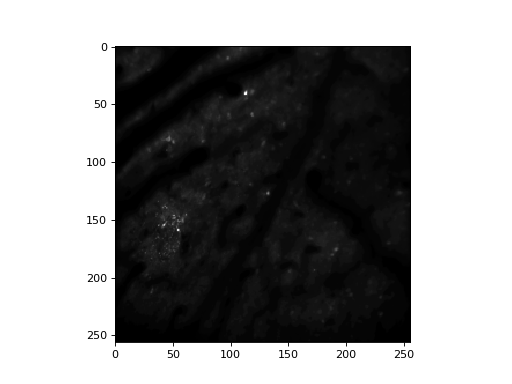

In [8]:
pl.figure()
pl.imshow(fov_img, 'gray')


# Format data

In [9]:
print processed_fpaths[0]
# Comine all trial data into data frames:
fit, magratio, phase, trials_by_cond = vf.trials_to_dataframes(processed_fpaths, conditions_fpath)
#print fit.head()
print trials_by_cond


# Correct phase to wrap around:
corrected_phase = vf.correct_phase_wrap(phase)



/n/coxfs01/2p-data/JC076/20190406/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_74a7c7/files/retino_data_FOV1_zoom2p0x_retino_run1_Slice01_Channel01_File001.h5
TRIALS BY COND:
{u'top': [22, 3, 2, 9, 8, 12], u'right': [24, 23, 5, 7, 11, 13], u'bottom': [20, 21, 10, 15, 19, 18], u'left': [1, 4, 6, 14, 17, 16]}
Trials: [24, 20, 21, 22, 23, 1, 3, 2, 5, 4, 7, 6, 9, 8, 11, 10, 13, 12, 15, 14, 17, 16, 19, 18]
1: retino_data_FOV1_zoom2p0x_retino_run1_Slice01_Channel01_File001.h5
2: retino_data_FOV1_zoom2p0x_retino_run1_Slice01_Channel01_File002.h5
3: retino_data_FOV1_zoom2p0x_retino_run1_Slice01_Channel01_File003.h5
4: retino_data_FOV1_zoom2p0x_retino_run1_Slice01_Channel01_File004.h5
5: retino_data_FOV1_zoom2p0x_retino_run1_Slice01_Channel01_File005.h5
6: retino_data_FOV1_zoom2p0x_retino_run1_Slice01_Channel01_File006.h5
7: retino_data_FOV1_zoom2p0x_retino_run1_Slice01_Channel01_File007.h5
8: retino_data_FOV1_zoom2p0x_retino_run1_Slice01_Channel01_File008.h5
9: retino_data_FOV1_zoom2p

## Get screen info

In [10]:
# Get screen info:
screen = visroi.get_screen_info(animalid, session, rootdir=rootdir)


# Convert phase to linear coords:
screen_left = -1*screen['azimuth']/2.
screen_right = screen['azimuth']/2. #screen['azimuth']/2.
screen_lower = -1*screen['elevation']/2.
screen_upper = screen['elevation']/2. #screen['elevation']/2.


Found epi sessions: []
No EPI maps found for session: %s * (trying to use tmp session boundaries file)
('-- getting screen info from:', ['/n/coxfs01/2p-data/JC076/epi_maps/screen_boundaries_tmp.json'])
*********************************
{   'azimuth': 117.5584,
    'bb_left': -58.7792,
    'bb_lower': -33.6615,
    'bb_right': 58.7792,
    'bb_upper': 33.6615,
    'elevation': 67.323,
    'resolution': [1024, 768]}
*********************************


#### Get list of "best fit" or highest-mag ratio ROIs:

In [11]:
from pipeline.python.retinotopy import utils as rutils


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julianarhee/anaconda2/en

In [31]:
fit_thr = 0.05

mag_thr = magratio.mean(axis=1).max() * 0.5 #0.02

mag_thr_stat = 'allconds'
use_fit = False


mean_fits = fit.mean(axis=1)
best_fits = mean_fits[mean_fits >= fit_thr].index.tolist()


mean_magratios = pd.concat((pd.Series(magratio[trials_by_cond[cond]].mean(axis=1), name=cond) \
                                     for cond in trials_by_cond.keys()), axis=1)
best_mags = rutils.select_rois(mean_magratios, mag_thr=mag_thr, mag_thr_stat=mag_thr_stat)
    
print "-----------------------------------"
if use_fit: 
    print "Filtering ROIs by best fit."
    top_rois = copy.copy(best_fits)
else:
    print "Filtering ROIs by strongest mag-ratios."
    top_rois = copy.copy(best_mags)

print "Strongest cells (n=%i, mag-ratio >= %.2f):" % (len(top_rois), mag_thr)
print top_rois                   
print "-----------------------------------"

#best_fits = np.array(absolute_coords['strong_cells'])


-----------------------------------
Filtering ROIs by strongest mag-ratios.
Strongest cells (n=9, mag-ratio >= 0.03):
[  4   8  11  18  40  43  62 132 200]
-----------------------------------


#### Load traces averaged by condition:

In [32]:
# This file gets created with visualization/get_session_summary() when estimate_RF_size.py is used

avg_traces_fpath = glob.glob(os.path.join(processed_dir, 'traces', '*.pkl'))
if len(avg_traces_fpath) == 0:
    print "Getting averaged ROI traces by cond and estimating RFs..."
    # Need to run estimate_RF_size.py:
    est.estimate_RFs_and_plot(['-i', animalid,'-S', session, '-A', fov, '-R', run, '-r', retinoid])
    avg_traces_fpath = glob.glob(os.path.join(processed_dir, 'traces', '*.pkl'))[0]
else:
    avg_traces_fpath = avg_traces_fpath[0]
    
print("Loading pre-averaged traces from: %s" % avg_traces_fpath)

with open(avg_traces_fpath, 'rb') as f:
    traces = pkl.load(f)
print("averaged_traces.pkl contains:", traces.keys())

# trials_by_cond = traces['conditions']
# print("Conditions (by rep):", trials_by_cond)

print "Cond dict:", traces['traces']['right']

Loading pre-averaged traces from: /n/coxfs01/2p-data/JC076/20190406/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_74a7c7/traces/averaged_roi_traces.pkl
('averaged_traces.pkl contains:', ['source_tifs', 'traces', 'RETINOID', 'masks', 'mwinfo', 'conditions'])
Cond dict: {'info': {'stimulus': u'right', 'stimfreq': 0.13, 'frame_rate': 44.6229, 'n_reps': 6}, 'traces': array([[-3.12894708, -1.83221062, -2.82486334, ...,  0.6604179 ,
        -0.16461594, -0.67229335],
       [-1.61853145, -1.78607915, -3.53895985, ...,  0.09599235,
         1.07409364,  0.78878407],
       [ 1.76674825,  2.73536643,  3.45098096, ..., -1.67936311,
        -0.40946695, -1.34077455],
       ..., 
       [-0.63036511,  0.20579464,  1.33532521, ..., -1.18290597,
        -0.31651555,  0.11443173],
       [ 2.1639648 ,  2.43055833,  1.24941039, ..., -0.51284243,
         0.10785465,  1.41468965],
       [ 0.54410308,  1.0262828 ,  1.81034902, ...,  1.42400271,
         1.29959088, -0.19651777]])}


#### Get stimulus info

In [33]:
# Get cycle starts:
cond = 'right'
stimfreq = traces['traces'][cond]['info']['stimfreq']
stimperiod = 1./stimfreq # sec per cycle
fr = traces['traces'][cond]['info']['frame_rate']
nframes = traces['traces'][cond]['traces'].shape[-1]

ncycles = int(round((nframes/fr) / stimperiod))
print stimperiod

nframes_per_cycle = int(np.floor(stimperiod * fr))
cycle_starts = np.round(np.arange(0, stimperiod*fr*ncycles, nframes_per_cycle)).astype('int')
print("Cycle starts (%i cycles):" % (ncycles), cycle_starts)


frame_period = 1./fr
t_frames = np.arange(frame_period, frame_period * (nframes+1), frame_period)
print t_frames[0:5]

# rinfo_fpath = glob.glob(os.path.join(run_dir, '*.json'))[0]
# with open(rinfo_fpath, 'r') as f:
#     rinfo = json.load(f)
# print rinfo['frame_tstamps_sec'][0:5]
# t_frames = np.array(rinfo['frame_tstamps_sec'])

t = t_frames * (2*np.pi) * stimfreq


7.69230769231
('Cycle starts (12 cycles):', array([   0,  343,  686, 1029, 1372, 1715, 2058, 2401, 2744, 3087, 3430,
       3773, 4116]))
[ 0.02241002  0.04482004  0.06723005  0.08964007  0.11205009]


In [34]:
# # Set params

# use_cos = True
use_corrected = False
if use_corrected:
    highval = 2*np.pi # np.pi
    lowval = 0 #-np.pi
    phase_array = corrected_phase.copy()
else:
    highval = np.pi
    lowval = -np.pi
    phase_array = phase.copy()

In [35]:
conditions = traces['conditions'].keys()

# Absolute retinotopy with delay (ROIs)

In [36]:
absolute_maps_dir = os.path.join(processed_dir, 'visualization', 'absolute_maps')
if not os.path.exists(absolute_maps_dir):
    os.makedirs(absolute_maps_dir)
print "Saving figures to:", absolute_maps_dir

Saving figures to: /n/coxfs01/2p-data/JC076/20190406/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_74a7c7/visualization/absolute_maps


In [37]:
# 1. Condition1 map
# ---------------------------------------------------------------

def draw_condition_masks(cmask, cname='right', axis='azimuth', cbar_axes=None, phasewrap=True, transpose=True, 
                         transform=False, fig=None, ax=None):
    
    if ax is None:
        fig, ax = pl.subplots()

    if cbar_axes is None:
        cbar_axes = [0, 0, 0.1, 0.05]
            
    cbar_orientation = 'horizontal' if axis=='azimuth' else 'vertical'
        
    if phasewrap:
        cmask_wrap = vf.correct_phase_wrap(cmask) # Transpose to get same orientation as FOV
        vmin=0; vmax=2*np.pi;
    else:
        cmask_wrap = cmask.copy()
        vmin=-np.pi; vmax=np.pi
    
    if transpose:
        cmask_wrap = cmask_wrap.T
        
    if transform:
        cmask_img = np.fliplr(np.rot90(cmask_wrap))
    else: 
        cmask_img = cmask_wrap.copy()
    im = ax.imshow(cmask_img, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(cname); ax.axis('off')
    
    if len(cbar_axes) > 0:
        cbaxes = fig.add_axes(cbar_axes) 
        cb = pl.colorbar(im, cax = cbaxes, orientation=cbar_orientation)  
        if cname=='right':
            cb.ax.invert_xaxis()
        elif cname=='top':
            cb.ax.invert_yaxis() 

    return ax

In [38]:
def plot_absolute_maps_rois(fov_img, cmask1, cmask2, delaymask, axis='azimuth', 
                            cmap='nipy_spectral', transform=False, \
                            threshold_delay_calc=True, use_mean_delay=False, mag_thr=0):

    if axis=='azimuth':
        c1 = 'left'; c2 = 'right';
    else:
        c1 = 'bottom'; c2 = 'top';
        
    fig, axes = pl.subplots(3,3, figsize=(8,15)) #pl.figure()
    pl.subplots_adjust(hspace=0.2, wspace=0.15, top=0.8, left=0.01, right=0.99, bottom=0.01)

    cbar_axes1 = [0.1, 0.8, 0.2, 0.05]
    cbar_axes2 = [0.4, 0.8, 0.2, 0.05]
    cbar_axes3 = [0.7, 0.8, 0.2, 0.05]

    cbar_axes1a = [0.1, 0.52, 0.2, 0.05]
    cbar_axes2a = [0.4, 0.52, 0.2, 0.05]
    cbar_axes3a = [0.7, 0.52, 0.2, 0.05]

    if transform:
        fov_img = np.fliplr(np.rot90(fov_img))
        
    # 1. Condition1 map
    # ---------------------------------------------------------------
    ax = axes[0, 0]
    ax.imshow(fov_img, 'gray')
    draw_condition_masks(cmask1, cname=c1, phasewrap=True, transpose=True, axis=axis,
                         cbar_axes=cbar_axes1, transform=transform, fig=fig, ax=ax)

    # 2.  Condition2 map
    # ---------------------------------------------------------------
    ax = axes[0, 1]
    ax.imshow(fov_img, 'gray')
    draw_condition_masks(cmask2, cname=c2, phasewrap=True, transpose=True, axis=axis,
                         cbar_axes=cbar_axes2, transform=transform, fig=fig, ax=ax)

    # 3.  Delay map:
    # ---------------------------------------------------------------
    ax = axes[0, 2]
    ax.imshow(fov_img, 'gray')
    delay_map = ((cmask1 + cmask2) / 2.).T
    mean_delay_val = delay_map.mean()
    ax = draw_condition_masks(delay_map, cname='delay', axis=axis,
                              phasewrap=False, transpose=False,
                              cbar_axes=cbar_axes3, transform=transform, fig=fig, ax=ax)
    ax.annotate('avg delay: %.2f' % mean_delay_val, (0, 0.5))
    # ---------------------------------------------------------------
    ax = axes[1, 2]
    ax.imshow(fov_img, 'gray')
    delay_map_thr = delaymask.T
    mean_delay_val_thr = delay_map_thr.mean()
    ax = draw_condition_masks(delay_map_thr, cname='delay (magthr)', axis=axis,
                              phasewrap=False, transpose=False,
                              cbar_axes=cbar_axes3a, transform=transform, fig=fig, ax=ax)
    magthr_str = '%.2f' % mag_thr if threshold_delay_calc else 'none'
    ax.set_title('delay - magthr? (%s)' % magthr_str); ax.axis('off')
    ax.annotate('avg delay: %.2f' % mean_delay_val_thr, (0, 0.5))
    # ---------------------------------------------------------------

    # 4. Abs map - cond1 
    # ---------------------------------------------------------------
    ax = axes[1, 0]
    ax.imshow(fov_img, 'gray')
    abs_map1 = ((vf.correct_phase_wrap(cmask1) - vf.correct_phase_wrap(cmask2)) / 2.).T
    #abs_map1 = vf.correct_phase_wrap(abs_map1) <-- dont do this if starting w/ corrected
    print "c1 abs:", abs_map1.min(), abs_map1.max()
    ax = draw_condition_masks(abs_map1, cname='abs', axis=axis,
                              phasewrap=False, transpose=False,
                              cbar_axes=cbar_axes1a, transform=transform, fig=fig, ax=ax)

    # 5. Abs map - cond2
    # ---------------------------------------------------------------
    ax = axes[1, 1]
    ax.imshow(fov_img, 'gray')
    abs_map2 = (-(vf.correct_phase_wrap(cmask2) - vf.correct_phase_wrap(cmask1)) / 2.).T
    ax = draw_condition_masks(abs_map2, cname='abs (+ reverse)', axis=axis,
                              phasewrap=False, transpose=False,
                              cbar_axes=cbar_axes2a, transform=transform, fig=fig, ax=ax)

    # 6. Cond1, shifted by delay
    # ---------------------------------------------------------------
    ax = axes[2, 0]
    ax.imshow(fov_img, 'gray')
    if use_mean_delay:
        shift_val = mean_delay_val_thr if threshold_delay_calc else mean_delay_val
        shift_map1 = cmask1.T - shift_val
    else:
        shift_values_map = delay_map_thr.copy() if threshold_delay_calc else delay_map.copy()
        shift_map1 = cmask1.T - shift_values_map
    print "c1 shifted:", shift_map1.min(), shift_map1.max()
    ax = draw_condition_masks(shift_map1, cname='%s - delay' % c1, axis=axis,
                              phasewrap=True, transpose=False,
                              cbar_axes=[], transform=transform, fig=fig, ax=ax)
    
    # 7. Cond2, shifted by delay
    # ---------------------------------------------------------------
    ax = axes[2, 1]
    ax.imshow(fov_img, 'gray')
    if use_mean_delay:
        shift_val = mean_delay_val_thr if threshold_delay_calc else mean_delay_val
        shift_map2 = -(cmask2.T - shift_val)
    else:
        shift_values_map = delay_map_thr.copy() if threshold_delay_calc else delay_map.copy()
        shift_map2 = -(cmask2.T - shift_values_map) 
    ax = draw_condition_masks(shift_map2, cname='%s - delay (+ rev)' % c2, axis=axis,
                              phasewrap=True, transpose=False,
                              cbar_axes=[], transform=transform, fig=fig, ax=ax)

    axes[1,2].axis('off')
    axes[2,2].axis('off')


    return fig


In [43]:
### Load masks

masks = traces['masks']
nrois, d1, d2 = masks.shape

print "Phases are corrected:", use_corrected
print "high/low = %.2f, %.2f" % (highval, lowval)
mean_phases = pd.concat(pd.DataFrame((pd.Series(data=sp.stats.circmean(phase_array[trials_by_cond[cond]].iloc[rid], high=highval, low=lowval),\
                        name=cond, index=[rid])) for cond in conditions).T for rid in phase_array.index.tolist())

print mean_phases.head()

# if not use_corrected:
#     print("correcting phase")
#     mean_phases = vf.correct_phase_wrap(mean_phases)



# mean_magratios = pd.concat((pd.Series(magratio[trials_by_cond[cond]].mean(axis=1), name=cond) \
#                                      for cond in trials_by_cond.keys()), axis=1)

max_magratios_by_roi = mean_magratios.max(axis=1)
max_magratios_best_fit = max_magratios_by_roi[best_fits]

mag_thr = max_magratios_by_roi.max() * 0.5
print mag_thr
best_mags = max_magratios_best_fit[max_magratios_best_fit>=mag_thr].index.tolist()

print "Found %i (out of %i) rois with mag-ratio > thr %.2f (and fit thr: %.2f)" % (len(best_mags), len(best_fits), mag_thr, fit_thr)

Phases are corrected: False
high/low = 3.14, -3.14
        top     right    bottom      left
0 -0.802397 -0.955042  2.651172  2.101767
1  0.317686 -1.372396  1.460862 -0.338732
2 -0.419719 -0.484403  3.137160 -2.535918
3  0.398323 -0.782350  2.995046  2.015864
4 -1.610047 -0.474440 -2.006915  2.959992
0.0358522794574
Found 22 (out of 176) rois with mag-ratio > thr 0.04 (and fit thr: 0.05)


In [44]:
mean_magratios_by_roi = mean_magratios.mean(axis=1)
ordered_by_mean_mags = np.argsort(mean_magratios_by_roi[best_mags].values)[::-1]
ordered_by_max_mags = np.argsort(max_magratios_by_roi[best_mags].values)[::-1]

#print best_mags
#print ordered_best_mags
sorted_by_mean_mag = [best_mags[i] for i in ordered_by_mean_mags]
sorted_by_max_mag = [best_mags[i] for i in ordered_by_max_mags]
print sorted_by_mean_mag

sorting = {'best_fits': best_fits,
           'best_mags': best_mags,
           'fit_thr': fit_thr,
           'mag_thr': mag_thr,
           'sorted_by_mean_mag': sorted_by_mean_mag,
           'sorted_by_max_mag': sorted_by_max_mag}

# Dump this info:
print absolute_maps_dir

with open(os.path.join(absolute_maps_dir, 'roi_indices_sorted_by_mean_magratio.json'), 'w') as f:
    json.dump(sorting, f, indent=4, sort_keys=True)

[8, 43, 62, 132, 11, 40, 6, 200, 78, 67, 7, 4, 195, 18, 32, 38, 2, 12, 5, 56, 16, 41]
/n/coxfs01/2p-data/JC076/20190406/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_74a7c7/visualization/absolute_maps


In [45]:
mag_thr

0.03585227945738325

### Calculate relative, absolute, and delay

In [54]:
# First look at left v. right:

axis = 'altitude'
threshold_by_fit = True
threshold_delay_calc = True
cmap='nipy_spectral_r'
transform=False
use_mean_delay = True


if axis == 'azimuth':
    c1 = 'left'
    c2 = 'right'
else:
    c1 = 'bottom'
    c2 = 'top'
    axis = 'altitude' # make sure not mistaken

In [55]:
# Calculate an average delay value using strongest ROIs:
mean_delays_thr = (mean_phases[c1][best_mags] + mean_phases[c2][best_mags]) / 2.
mean_delays = (mean_phases[c1] + mean_phases[c2]) / 2.

print mean_delays_thr.mean(), mean_delays_thr.shape
print mean_delays.mean(), mean_delays.shape

tmp_cmask1 = np.ones((d1, d2))*100
tmp_cmask2 = np.ones((d1, d2)) *100
tmp_delaymask = np.ones((d1, d2)) *100

if threshold_by_fit:
    roi_list = copy.copy(best_fits)
else:
    roi_list = np.arange(0, nrois)
    
for ri in roi_list: #np.arange(0, nrois):
    maskpix = np.where(np.squeeze(masks[ri,:,:])) 
    
    tmp_cmask1[maskpix] = mean_phases[c1][ri] 
    tmp_cmask2[maskpix] = mean_phases[c2][ri]
    
    if threshold_delay_calc:
        if ri in best_mags:
            tmp_delaymask[maskpix] = mean_delays_thr[ri]
    else:
        tmp_delaymask[maskpix] = mean_delays[ri]
        
    tmp_cmask1 = np.ma.array(tmp_cmask1) # create masking array
    cmask1 = np.ma.masked_where(tmp_cmask1 == 100 , tmp_cmask1) # mask non-roi pixels

    tmp_cmask2 = np.ma.array(tmp_cmask2) # create masking array
    cmask2 = np.ma.masked_where(tmp_cmask2 == 100 , tmp_cmask2) # mask non-roi pixels

    tmp_delaymask = np.ma.array(tmp_delaymask)
    delaymask = np.ma.masked_where(tmp_delaymask == 100, tmp_delaymask)

-0.855864761045 (22,)
0.125563757429 (247,)


<IPython.core.display.Javascript object>


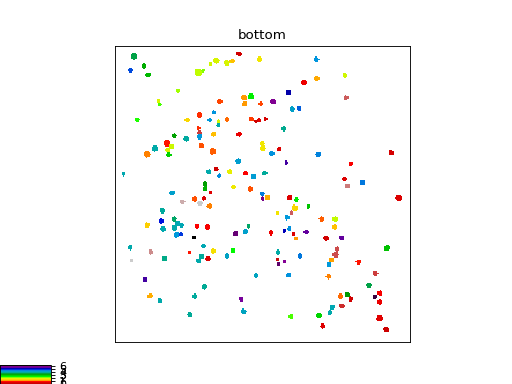

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  """


<IPython.core.display.Javascript object>


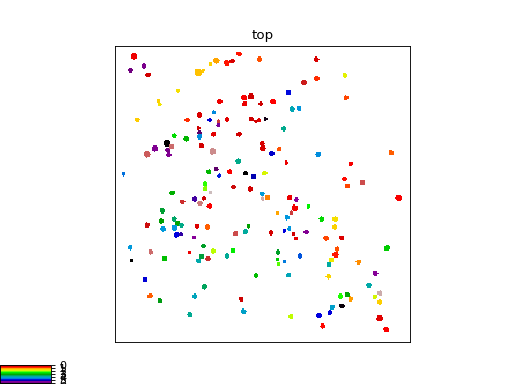

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


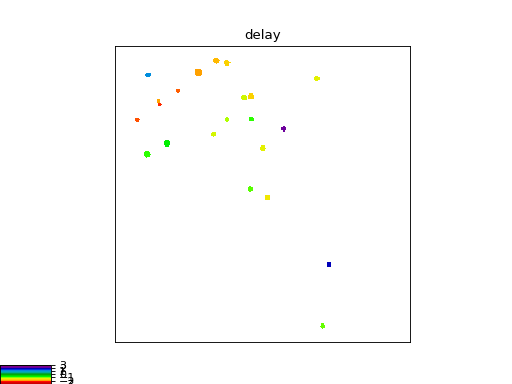

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


<IPython.core.display.Javascript object>


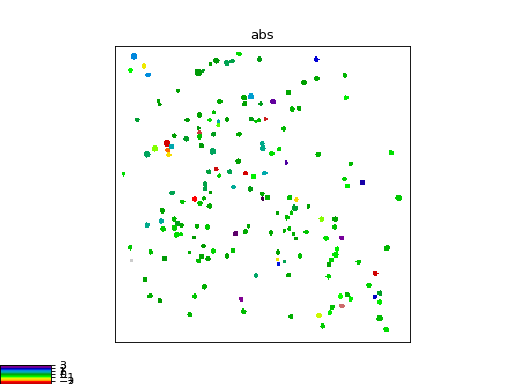

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [56]:
fig, ax = pl.subplots()
ax = draw_condition_masks(cmask1, cname=c1, phasewrap=True, transpose=True, axis=axis,
                         cbar_axes=None, transform=transform, fig=fig, ax=ax)
ax.axis('on'); ax.set_xticks([]); ax.set_yticks([]); ax.set_xticklabels([]); ax.set_yticklabels([]);
ax.set_axis_bgcolor('none')
pl.savefig(os.path.join(absolute_maps_dir, '%s_masks.png' % c1))

fig, ax = pl.subplots()
ax = draw_condition_masks(cmask2, cname=c2, phasewrap=True, transpose=True, axis=axis,
                         cbar_axes=None, transform=transform, fig=fig, ax=ax)
ax.axis('on'); ax.set_xticks([]); ax.set_yticks([]); ax.set_xticklabels([]); ax.set_yticklabels([]);
ax.set_axis_bgcolor('none')
pl.savefig(os.path.join(absolute_maps_dir, '%s_masks.png' % c2))

fig, ax = pl.subplots()
ax = draw_condition_masks(delaymask, cname='delay', phasewrap=False, transpose=True, axis=axis,
                         cbar_axes=None, transform=transform, fig=fig, ax=ax)
ax.axis('on'); ax.set_xticks([]); ax.set_yticks([]); ax.set_xticklabels([]); ax.set_yticklabels([]);
ax.set_axis_bgcolor('none')
pl.savefig(os.path.join(absolute_maps_dir, 'delay_masks_%s.png' % axis))


fig, ax = pl.subplots()
abs_map1 = ((vf.correct_phase_wrap(cmask1) - vf.correct_phase_wrap(cmask2)) / 2.).T
ax = draw_condition_masks(abs_map1, cname='abs', axis=axis,
                          phasewrap=False, transpose=False,
                          cbar_axes=None, transform=transform, fig=fig, ax=ax)
ax.axis('on'); ax.set_xticks([]); ax.set_yticks([]); ax.set_xticklabels([]); ax.set_yticklabels([]);
ax.set_axis_bgcolor('none')
pl.savefig(os.path.join(absolute_maps_dir, 'absolute_masks_%s.png' % axis))



# Plot absolute maps

<IPython.core.display.Javascript object>


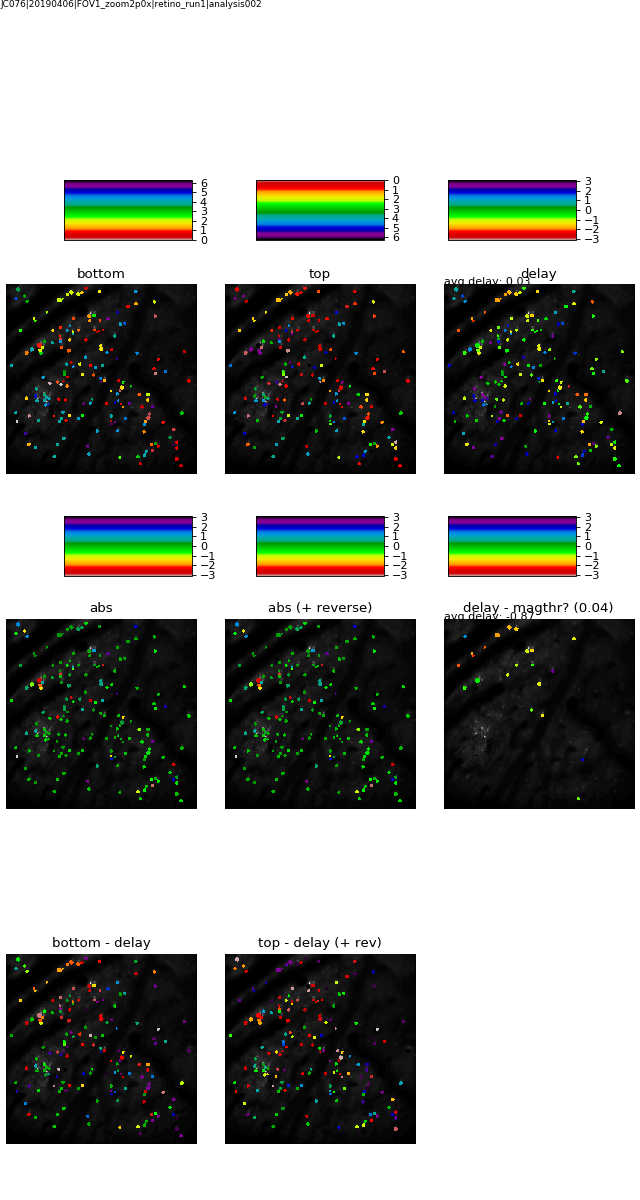

c1 abs: -3.13123913369 2.94556209571
c1 shifted: -2.19952095557 4.00795676228
absolute_phase_by_roi_bottom_top_fitthr0.05_thresh-delay-magthr0.04_shift-mean-delay-val
Delay: -0.870797185525
bottom (mean): 0.07
top (mean): -0.01


In [57]:

fig = plot_absolute_maps_rois(fov_img, cmask1, cmask2, delaymask, axis=axis, 
                              cmap=cmap, transform=transform, use_mean_delay=use_mean_delay,
                              threshold_delay_calc=threshold_delay_calc, mag_thr=mag_thr)

label_figure(fig, data_identifier)

if threshold_by_fit: 
    figname = 'absolute_phase_by_roi_%s_%s_fitthr%.2f' % (c1, c2, fit_thr)
else:
    figname = 'absolute_phase_by_roi_%s_%s_all' % (c1, c2)
    
if threshold_delay_calc:
    figname = '%s_thresh-delay-magthr%.2f' % (figname, mag_thr)


if use_mean_delay:
    figname = '%s_shift-mean-delay-val' % figname
    
if transform:
    figname = '%s_transformed' % figname

#pl.savefig(os.path.join(absolute_maps_dir, '%s.png' % figname))
print figname

print "Delay:", delaymask.mean()
print "%s (mean): %.2f" % (c1, cmask1.mean()) # cmask2.max()
print "%s (mean): %.2f" % (c2, cmask2.mean()) # cmask2.max()


#print "%s - %s: max/min = %.2f, %.2f" % (c1, c2, abs_map1.max(),abs_map1.min())
#print "%s - %s: max/min = %.2f, %.2f" % (c2, c1, abs_map2.max(),abs_map2.min())

# Test delay with PIXEL maps

In [14]:
# Get AVERAGE across all reps per condition:
# -------------------------------------------------------
mean_phase_list = []
for cond in trials_by_cond.keys():
    curr_phase_values = phase[trials_by_cond[cond]]
    curr_phase_means = sp.stats.circmean(curr_phase_values, axis=1, low=-np.pi, high=np.pi)
    mean_phase_list.append(pd.Series(curr_phase_means, name=cond))
    
mean_phases = pd.concat(mean_phase_list, axis=1)
mean_phases.head()


,top,right,left,bottom
0,-2.536898,0.047199,-0.364383,-0.996411
1,2.310248,-1.366605,0.120409,1.629760
2,-2.872898,-1.637477,0.578666,0.192356
3,-2.843380,-0.009587,0.079594,2.381518
4,3.081715,-1.738582,0.297128,2.146732


In [15]:
# Get average MAGNITUDE-RATIOS across reps per condition:
# -------------------------------------------------------
# print magratio.shape
# magratio.head()

mean_magratios = pd.concat((pd.Series(magratio[trials_by_cond[cond]].mean(axis=1), name=cond) \
                                     for cond in trials_by_cond.keys()), axis=1)
mean_magratios.head()
    

,top,right,left,bottom
0,0.004768,0.003584,0.004713,0.004160
1,0.003439,0.004916,0.003221,0.005694
2,0.004486,0.007122,0.005065,0.006095
3,0.004550,0.002247,0.007044,0.004713
4,0.004293,0.003328,0.007740,0.003727


In [16]:
mag_thr = mean_magratios.max().max()*0.3
print mag_thr
max_mags_by_roi = mean_magratios.max(axis=1)
strong_pixels = max_mags_by_roi[max_mags_by_roi>=mag_thr].index.tolist()
print "Found %i pixels that pass mag-ratio min threshold of %.2f" % (len(strong_pixels), mag_thr)


0.0222506918865
Found 3184 pixels that pass mag-ratio min threshold of 0.02


In [17]:
# Compare L/R and U/D to check for delay in GCaMP signal:
az = ['right', 'left']
el = ['top', 'bottom']

delay_az = mean_phases[az].sum(axis=1) / 2.
delay_el = mean_phases[el].sum(axis=1) / 2.

mean_delay_az = delay_az.iloc[strong_pixels].mean()
mean_delay_el = delay_el.iloc[strong_pixels].mean()
print "[AZ]: mean delay is %.2f" % mean_delay_az
print "[EL]: mean delay is %.2f" % mean_delay_el

d1 = int(np.sqrt(mean_magratios.shape[0]))
d2 = int(np.sqrt(mean_magratios.shape[0]))
print "dims:", d1, d2

[AZ]: mean delay is -0.21
[EL]: mean delay is 0.86
dims: 256 256


In [18]:

# Compare L/R and U/D to check for delay in GCaMP signal:
# az = ['right', 'left']
# el = ['top', 'bottom']


# # if use_corrected:
# #     phase_right = corrected_phase[trials_by_cond['right']]
# #     phase_left = corrected_phase[trials_by_cond['left']]
# #     phase_top = corrected_phase[trials_by_cond['top']]
# #     phase_bottom = corrected_phase[trials_by_cond['bottom']]

# delay_az = (avg_right + avg_left ) / 2.
# delay_el = (avg_top + avg_bottom ) / 2.

# overall_mag_ratios = magratio.mean(axis=1)
# print(overall_mag_ratios.shape)

# cmap = 'nipy_spectral'
# vmin = 0
# vmax = 2*np.pi
# d1 = int(np.sqrt(overall_mag_ratios.shape[0]))
# d2 = int(np.sqrt(overall_mag_ratios.shape[0]))


In [19]:
import cv2
from PIL import Image
from pipeline.python.segmentation import segmentation as seg

In [20]:
# fig, ax = pl.subplots()
# vmin = 0
# vmax = 2*np.pi

# left_shifted_corrected = vf.correct_phase_wrap(right_shifted)
# print left_shifted_corrected.min(), left_shifted_corrected.max()

# wrp = pd.Series((np.unwrap(left_shifted_corrected, discont=2*np.pi)))
# #sm = pd.rolling_mean(wrp, window=10)
# print wrp.min(), wrp.max()

# sigma = 10 #0
# sm = sp.ndimage.filters.gaussian_filter(np.reshape(wrp, (d1, d2)), sigma)



# lmap = np.reshape(sm, (d1, d2))
# im0 = ax.imshow(lmap, vmin=vmin, vmax=vmax, cmap='nipy_spectral')
# pl.colorbar(im0)

In [21]:
m = np.array([[1,2,3],
         [2,3,3],
         [5,4,3]])

def rotate_matrix(mat):
    return np.rot90(mat)

rmat = rotate_matrix(m)
print rmat

rmat2 = np.fliplr(np.rot90(m))
print rmat2

[[3 3 3]
 [2 3 4]
 [1 2 5]]
[[3 3 3]
 [4 3 2]
 [5 2 1]]


In [22]:
def get_absolute_maps_by_cond(avg_phases, axis='azimuth', smooth=True, sigma=10, cmap='nipy_spectral', transform=False):
    if axis == 'azimuth':
        c1 = 'left'
        c2 = 'right'
        cbar_orientation = 'horizontal'
    else:
        c1 = 'bottom'
        c2 = 'top'
        cbar_orientation = 'vertical'


    right_shifted = -(avg_phases[c2] - mean_delay_az)
    left_shifted = avg_phases[c1] - mean_delay_el
    abs_az = (avg_phases[c1] - avg_phases[c2] ) / 2.

    vmin=0
    vmax=2*np.pi

    fig, axes = pl.subplots(1,3)

    ax = axes[0]
    left_shifted_corrected = vf.correct_phase_wrap(left_shifted)
    if smooth:
        wrp = pd.Series((np.unwrap(left_shifted_corrected, discont=2*np.pi)))
        lmap = sp.ndimage.filters.gaussian_filter(np.reshape(wrp, (d1, d2)), sigma)
    else:
        lmap = np.reshape(left_shifted_corrected, (d1, d2))
    if transform:
        lmap = np.fliplr(np.rot90(lmap))
    im0 = ax.imshow(lmap, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_title('%s shifted' % c1)
    cbaxes = fig.add_axes([0.1, 0.9, 0.2, 0.05]) 
    cb = pl.colorbar(im0, cax = cbaxes, orientation=cbar_orientation)  


    ax = axes[1]
    right_shifted_corrected = vf.correct_phase_wrap(right_shifted)
    if smooth:
        wrp = pd.Series((np.unwrap(right_shifted_corrected, discont=2*np.pi)))
        rmap = sp.ndimage.filters.gaussian_filter(np.reshape(wrp, (d1, d2)), sigma)
    else:
        rmap = np.reshape(right_shifted_corrected, (d1, d2))
    if transform:
        rmap = np.fliplr(np.rot90(rmap))
    im1 = ax.imshow(rmap, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_title('%s shifted' % c2)
    cbaxes = fig.add_axes([0.4, 0.9, 0.2, 0.05]) 
    cb = pl.colorbar(im1, cax = cbaxes, orientation=cbar_orientation)  

    ax = axes[2]
    abs_corrected = vf.correct_phase_wrap(abs_az)
    if smooth:
        wrp = pd.Series((np.unwrap(abs_corrected, discont=2*np.pi)))
        absmap = sp.ndimage.filters.gaussian_filter(np.reshape(wrp, (d1, d2)), sigma)
    else:
        absmap = np.reshape(abs_corrected, (d1, d2))
    #absmap = np.reshape(vf.correct_phase_wrap(abs_az), (d1, d2))
    if transform:
        absmap = np.fliplr(np.rot90(absmap))
    im2 = ax.imshow(absmap, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_title('%s - %s' % (c1, c2))


    pl.subplots_adjust(bottom=0.05, top=0.85, wspace=0.5)
    # Now adding the colorbar
    cbaxes = fig.add_axes([0.7, 0.9, 0.2, 0.05]) 
    cb = pl.colorbar(im2, cax = cbaxes, orientation=cbar_orientation)  
    #cb.ax.invert_xaxis() 
    
    return fig


<IPython.core.display.Javascript object>


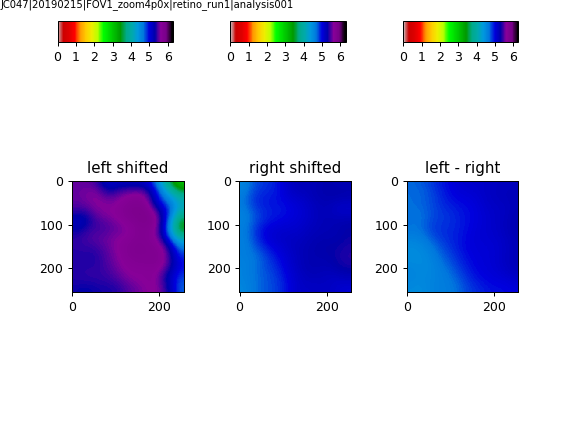

absolute_maps_azimuth_gauss20_transformed


<IPython.core.display.Javascript object>


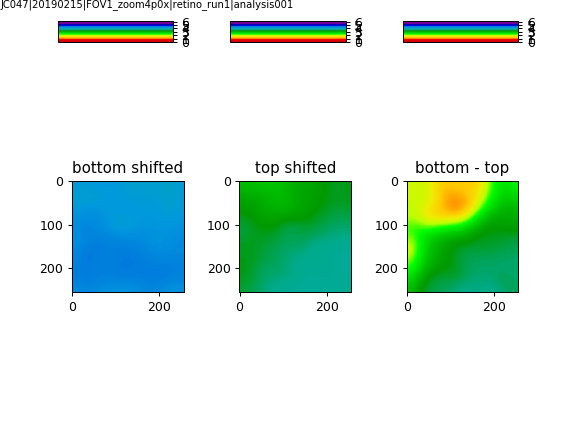

absolute_maps_altitude_gauss20_transformed


In [25]:

smooth = True
sigma = 20
cmap = 'nipy_spectral_r'
transform=True

if smooth:
    smooth_str = 'gauss%i' % sigma
else:
    smooth_str = 'raw'
    
trans_str = 'transformed' if transform else '2pfov'

axis = 'azimuth'
fig = get_absolute_maps_by_cond(mean_phases, axis=axis, smooth=smooth, sigma=sigma, cmap=cmap, transform=transform)
label_figure(fig, data_identifier)

figname = 'absolute_maps_%s_%s_%s' % (axis, smooth_str, trans_str)
pl.savefig(os.path.join(absolute_maps_dir, '%s.png' % figname))
print figname

axis = 'altitude'
fig = get_absolute_maps_by_cond(mean_phases, axis=axis, smooth=smooth, sigma=sigma, cmap=cmap, transform=transform)
label_figure(fig, data_identifier)

figname = 'absolute_maps_%s_%s_%s' % (axis, smooth_str, trans_str)
pl.savefig(os.path.join(absolute_maps_dir, '%s.png' % figname))
print figname


In [26]:


#%%%
for direction in [az, el]:
    assert len(direction) == 2, "Not enough directions found: %s" % str(direction)

    nreps = len(phase_right.columns.tolist())
    fig, axes = pl.subplots(2, nreps+1,figsize=(5*(nreps+1), 10))

    for cond_ix, cond in enumerate(direction):
        if cond == 'right':
            nreps = len(phase_right.columns.tolist())
            trial_phase_vals = phase_right.copy()
            avg_phase_vals = avg_right.copy()
        elif cond == 'left':
            nreps = len(phase_left.columns.tolist())
            trial_phase_vals = phase_left.copy()
            avg_phase_vals = avg_left.copy()
        elif cond == 'top':
            nreps = len(phase_top.columns.tolist())
            trial_phase_vals = phase_top.copy()
            avg_phase_vals = avg_top.copy()
        else:
            nreps = len(phase_bottom.columns.tolist())
            trial_phase_vals = phase_bottom.copy()
            avg_phase_vals = avg_bottom.copy()


        for trialnum in np.arange(0, nreps):
            axes[cond_ix, trialnum].imshow(trial_phase_vals[trials_by_cond[cond][trialnum]].reshape((d1, d2)), cmap=cmap, vmin=vmin, vmax=vmax)
            axes[cond_ix, trialnum].set_title('%s, rep %i' % (cond, trialnum))
            axes[cond_ix, trialnum].imshow(trial_phase_vals[trials_by_cond[cond][trialnum]].reshape((d1, d2)), cmap=cmap, vmin=vmin, vmax=vmax)
            axes[cond_ix, trialnum].set_title('%s, rep %i' % (cond, trialnum))
            axes[cond_ix, trialnum].axis('off')

            axes[cond_ix, nreps].imshow(avg_phase_vals.reshape((d1, d2)), cmap=cmap, vmin=vmin, vmax=vmax)
            axes[cond_ix, nreps].set_title('%s, average' % cond)
            axes[cond_ix, nreps].axis('off')
    
    label_figure(fig, data_identifier)
    pl.savefig(os.path.join(absolute_maps_dir, 'average_maps_%s.png' % direction))
    pl.close()
    

NameError: name 'phase_right' is not defined

### Calculate delay map:

<IPython.core.display.Javascript object>


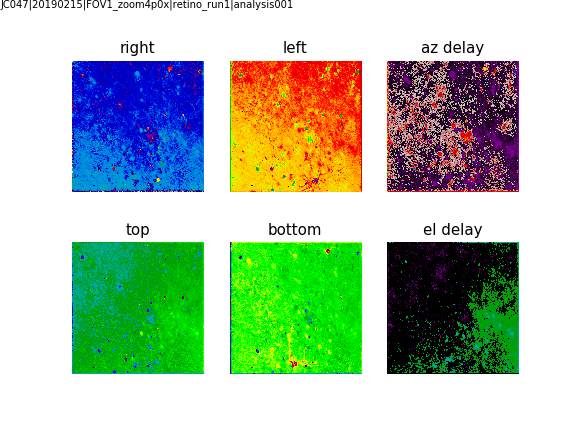

In [27]:
cmap='nipy_spectral'

vmin = 0
vmax = 2*np.pi

phasemap_right = np.reshape(mean_phases['right'], (d1, d2))
phasemap_left = np.reshape(mean_phases['left'], (d1, d2))
az_delay = (phasemap_left + phasemap_right) / 2.

phasemap_top = np.reshape(mean_phases['top'], (d1, d2))
phasemap_bottom = np.reshape(mean_phases['bottom'], (d1, d2))
el_delay = (phasemap_bottom + phasemap_top) / 2.

fig, ax = pl.subplots(2,3)

# Plot original RIGHT:
pmap_right = vf.correct_phase_wrap(phasemap_right)
im0 = ax[0, 0].imshow(pmap_right, cmap=cmap, vmin=vmin, vmax=vmax)
ax[0, 0].set_title('right'); ax[0, 0].axis('off');

# Plot original LEFT:
pmap_left = vf.correct_phase_wrap(phasemap_left)
im1 = ax[0, 1].imshow(pmap_left, cmap=cmap, vmin=vmin, vmax=vmax)
ax[0, 1].set_title('left'); ax[0, 1].axis('off')

# Plot AZ delay map:
pmap_delay_az = vf.correct_phase_wrap(az_delay)
ax[0, 2].imshow(pmap_delay_az, cmap=cmap, vmin=vmin, vmax=vmax)
ax[0, 2].set_title('az delay'); ax[0, 2].axis('off')



# Plot original TOP:
pmap_top = vf.correct_phase_wrap(phasemap_top)
im0 = ax[1, 0].imshow(pmap_top, cmap=cmap, vmin=vmin, vmax=vmax)
ax[1, 0].set_title('top'); ax[1, 0].axis('off');

# Plot original BOTTOM:
pmap_bottom = vf.correct_phase_wrap(phasemap_bottom)
im1 = ax[1, 1].imshow(pmap_bottom, cmap=cmap, vmin=vmin, vmax=vmax)
ax[1, 1].set_title('bottom'); ax[1, 1].axis('off')

# Plot EL delay map:
pmap_delay_el = vf.correct_phase_wrap(el_delay)
ax[1, 2].imshow(el_delay, cmap=cmap, vmin=vmin, vmax=vmax)
ax[1, 2].set_title('el delay'); ax[1, 2].axis('off')

label_figure(fig, data_identifier)
pl.savefig(os.path.join(absolute_maps_dir, 'delay_maps.png'))

<IPython.core.display.Javascript object>


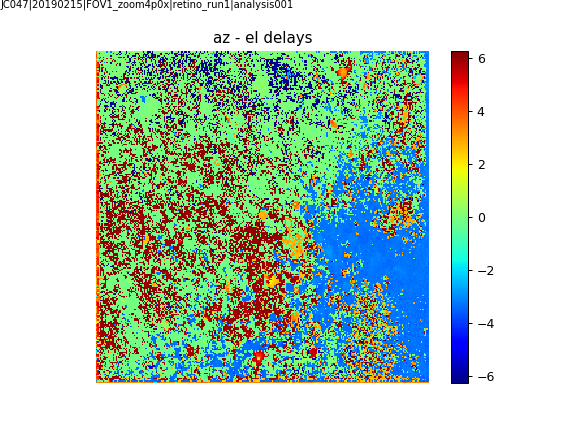

In [28]:
fig = pl.figure()
#pl.imshow(az_delay - el_delay, cmap='jet')
pl.imshow(pmap_delay_az - pmap_delay_el, cmap='jet')
pl.colorbar()
pl.axis('off')
pl.title('az - el delays')
label_figure(fig, data_identifier)
pl.savefig(os.path.join(absolute_maps_dir, 'delay_difference.png'))

<IPython.core.display.Javascript object>


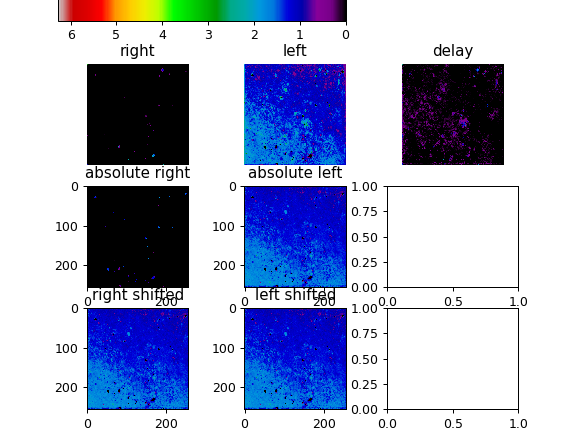

In [29]:

phasemap_right = np.reshape(mean_phases['right'], (d1, d2))
phasemap_left = np.reshape(mean_phases['left'], (d1, d2))

az_delay = (phasemap_left + phasemap_right) / 2.

fig, ax = pl.subplots(3,3)

# Plot original RIGHT:
im0 = ax[0, 0].imshow(phasemap_right, cmap=cmap, vmin=vmin, vmax=vmax)
ax[0, 0].set_title('right'); ax[0, 0].axis('off');

# Plot original LEFT:
im1 = ax[0, 1].imshow(phasemap_left, cmap=cmap, vmin=vmin, vmax=vmax)
ax[0, 1].set_title('left'); ax[0, 1].axis('off')

# Plot AZ delay map:
ax[0, 2].imshow(az_delay, cmap=cmap, vmin=vmin, vmax=vmax)
ax[0, 2].set_title('delay'); ax[0, 2].axis('off')

# Plot absolute "right":
absolute_right = (phasemap_right - phasemap_left) / 2.
ax[1, 0].set_title('absolute right')
ax[1, 0].imshow(absolute_right, cmap=cmap, vmin=vmin, vmax=vmax)

# Plot absolute "left":
absolute_left = (phasemap_left - phasemap_right) / 2.
ax[1, 1].set_title('absolute left')
ax[1, 1].imshow(absolute_left, cmap=cmap, vmin=vmin, vmax=vmax)

# Plot right map, shifted by delay:
right_subtract_delay = -(phasemap_right-az_delay ) #(az_delay - phasemap_right)
ax[2, 0].set_title('right shifted')
ax[2, 0].imshow(right_subtract_delay, cmap=cmap, vmin=vmin, vmax=vmax)

# Plot left map, shifted by delay:
left_subtract_delay = (phasemap_left - az_delay)
ax[2, 1].set_title('left shifted')
ax[2, 1].imshow(left_subtract_delay, cmap=cmap, vmin=vmin, vmax=vmax)

pl.subplots_adjust(bottom=0.05, top=0.85)
# Now adding the colorbar
cbaxes = fig.add_axes([0.1, 0.95, 0.5, 0.05]) 
cb = pl.colorbar(im1, cax = cbaxes, orientation='horizontal')  
cb.ax.invert_xaxis() 
